# Прогнозирование оттока клиентов банка

Мне предоставлены исторические о поведении клиентов и расторжении договоров с банком. Необходимо спрогонозировать, уйдет ли клиент в ближайшее время или нет.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle

## Изучение и ознакомление с данными

In [2]:
churn = pd.read_csv('C:\\Users\\yansa\\YP_Projects\\YP_DataSets\\SP6\\Churn.csv')

In [3]:
churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Присутствуют 909 пропусков в колонке Tenure, 3 колонки строкового формата.

In [5]:
churn.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [6]:
churn.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
quantitive = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
categorical = ['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']

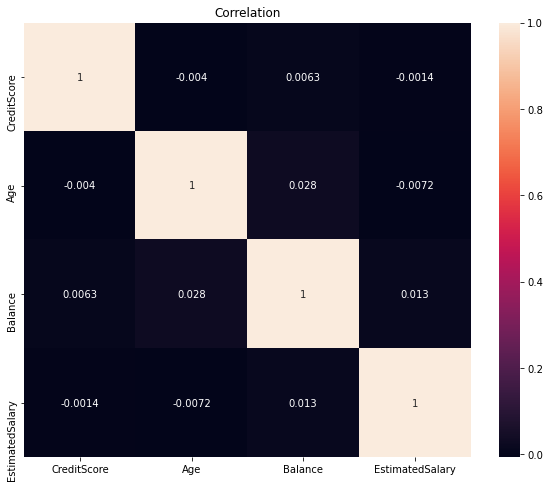

In [8]:
plt.figure(figsize=(10, 8))
plot = sns.heatmap(churn[quantitive].corr(), annot=True)
plot.set_title('Correlation');

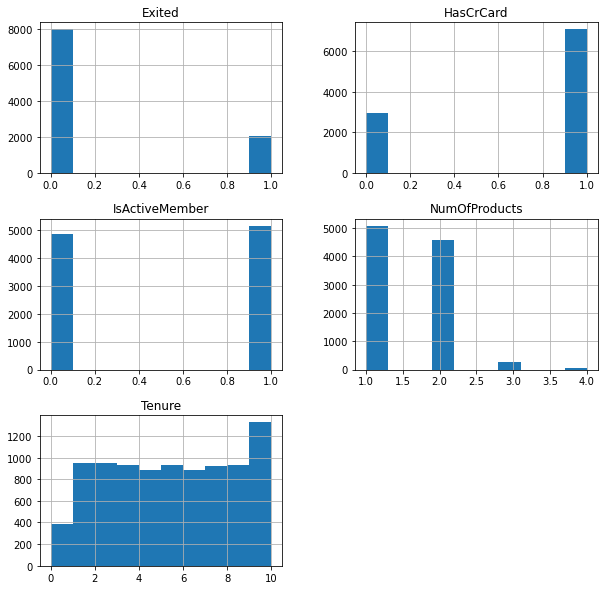

In [9]:
churn[categorical].hist(figsize=(10,10));

Сильной корреляции между признаками не обнаружено.

## Предобработка данных

Чтобы не терять данные и не вносить дисбаланс, заполняю пропущенные значения колонки Tenure случайным числом, которое уже есть в этой колонке (от 0 до 10).

In [10]:
def random_digit(row):
    tenure = row['Tenure']
    if tenure >= 0:
        return tenure
    else:
        return random.randint(0,10)

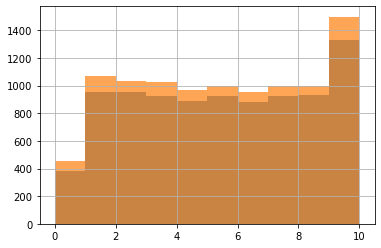

In [11]:
churn['Tenure'].hist(alpha=0.8);
churn['Tenure'] = churn.apply(random_digit, axis=1)
churn['Tenure'].hist(alpha=0.7);

In [12]:
churn['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0.])

Убираю из исходного датафрейма колонки RowNumber и CustomerId, так как они уникальны и не приносят добавленной стоимости для модели. Колонку Surname тоже убираю.

In [13]:
churn = churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Подготовим категориальные данные для обучения: методом One-Hot Encoding для логистической регрессии и методом Ordinal Encoding для обучения деревьями. Все преобразования оставим в одной таблице, а перед обучением будем удалять ненужные.

In [14]:
churn = churn.join(pd.get_dummies(churn[['Geography', 'Gender']], drop_first=True))

In [15]:
ordinal = pd.DataFrame(OrdinalEncoder().fit_transform(churn[['Geography', 'Gender']]), 
                       columns=churn[['Geography', 'Gender']].columns)
churn['Geography'] = ordinal['Geography']
churn['Gender'] = ordinal['Gender']

In [16]:
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,0.0,0.0,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,2.0,0.0,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,0.0,0.0,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,0.0,0.0,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,2.0,0.0,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Отмасштабируем количественные признаки.

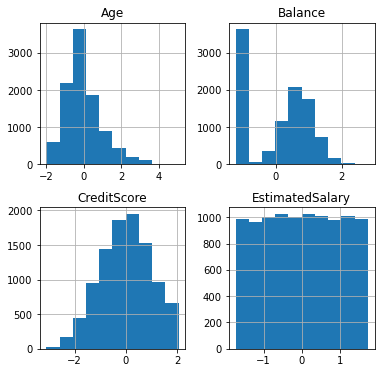

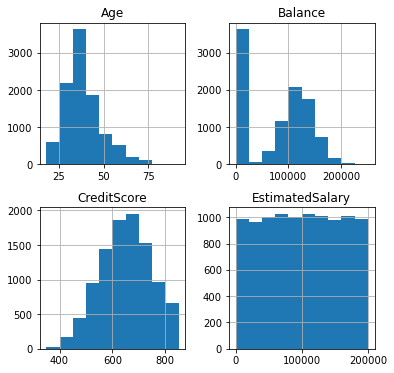

In [17]:
scaled = pd.DataFrame(StandardScaler().fit_transform(churn[['Balance', 'EstimatedSalary', 'Age', 'CreditScore']]), 
                      columns=churn[['Balance', 'EstimatedSalary', 'Age', 'CreditScore']].columns)
scaled.hist(figsize=(6,6));
churn[['Balance', 'EstimatedSalary', 'Age', 'CreditScore']].hist(figsize=(6,6));
churn['Balance'] = scaled['Balance']
churn['EstimatedSalary'] = scaled['EstimatedSalary']
churn['Age'] = scaled['Age']
churn['CreditScore'] = scaled['CreditScore']

In [18]:
churn.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.0,0.0,0.293517,2.0,-1.225848,1,1,1,0.021886,1,0,0,0
1,-0.440036,2.0,0.0,0.198164,1.0,0.117350,1,0,1,0.216534,0,0,1,0
2,-1.536794,0.0,0.0,0.293517,8.0,1.333053,3,1,0,0.240687,1,0,0,0
3,0.501521,0.0,0.0,0.007457,1.0,-1.225848,2,0,0,-0.108918,0,0,0,0
4,2.063884,2.0,0.0,0.388871,2.0,0.785728,1,1,1,-0.365276,0,0,1,0


Сделаю заготовки листов с параметрами для исключения ohe и ordinal колонок.

In [19]:
drop_ohe_columns = ['Geography_Germany', 'Geography_Spain', 'Gender_Male']
drop_ordinal_columns = ['Geography', 'Gender']

## Дисбаланс классов и подготовка данных к обучению

Разобью данные на 2 датасета: 1ый с параметрами, по которым предсказываем, 2ой с предсказываемым параметром.

In [20]:
x_churn = churn.drop('Exited', axis=1)
y_churn = churn['Exited']

Разделю датасеты на обучающую и тестовую выборку (бью на две части вместо трех, тк в дальнейшем планирую подбор параметров с помощью кроссвалидации). Использую stratify, чтобы сохранить пропорции при разбивке.

In [21]:
x_churn_train, x_churn_test, y_churn_train, y_churn_test = train_test_split(x_churn, y_churn, random_state=12345,
                                                                           stratify=churn['Exited'])
print(x_churn_train.shape, x_churn_test.shape, y_churn_train.shape, y_churn_test.shape)

(7500, 13) (2500, 13) (7500,) (2500,)


Проверяю правильно ли отработал stratify.

In [22]:
display(y_churn_train.value_counts()/y_churn_train.value_counts().sum())
display(y_churn_test.value_counts()/y_churn_test.value_counts().sum())

0    0.796267
1    0.203733
Name: Exited, dtype: float64

0    0.7964
1    0.2036
Name: Exited, dtype: float64

Учтем дисбаланс классов и подготовим дополнительные датафреймы с помощью апсеймплинга и даунсеймплинга.

#### Upsampling

In [23]:
'''
Функция upsample

features - датасет с параметрами по которым предсказываем
target  - датасет с предсказываемым параметром
zero_or_one - с каким результатом увеличить наблюдения: 0 или 1
method - 'coeff' (увеличиваем список в х раз) или 'samples' (увеличиваем до определенного кол-ва наблюдений)
digit - int значение либо coeff, либо samples, в зависимости от метода

'''
def upsample(features, target, zero_or_one, method, digit):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if method == 'samples':
        if zero_or_one == 0:
            features_upsampled = pd.concat([features_zeros.sample(digit, replace=True)] + [features_ones])
            target_upsampled = pd.concat([target_zeros.sample(digit, replace=True)] + [target_ones])  
            features_upsampled, target_upsampled = shuffle(
                features_upsampled, target_upsampled, random_state=12345)
            return features_upsampled, target_upsampled
        
        elif zero_or_one == 1:
            features_upsampled = pd.concat([features_zeros] + [features_ones.sample(digit, replace=True)])
            target_upsampled = pd.concat([target_zeros] + [target_ones.sample(digit, replace=True)])
            features_upsampled, target_upsampled = shuffle(
                features_upsampled, target_upsampled, random_state=12345)
            return features_upsampled, target_upsampled
        
        else:
            raise ValueError('Change "zero_or_one" parameter to 0 or 1')
            
    elif method == 'coeff':
        if zero_or_one == 0:
            features_upsampled = pd.concat([features_zeros] * digit + [features_ones])
            target_upsampled = pd.concat([target_zeros] * digit + [target_ones])  
            features_upsampled, target_upsampled = shuffle(
                features_upsampled, target_upsampled, random_state=12345)
            return features_upsampled, target_upsampled

        elif zero_or_one == 1:
            features_upsampled = pd.concat([features_zeros] + [features_ones] * digit)
            target_upsampled = pd.concat([target_zeros] + [target_ones] * digit)
            features_upsampled, target_upsampled = shuffle(
                features_upsampled, target_upsampled, random_state=12345)
            return features_upsampled, target_upsampled
        
        else:
            raise ValueError('Change "zero_or_one" parameter to 0 or 1')
            
    else:
        raise ValueError('Wrong parameters in function')

In [24]:
y_churn_train.value_counts()

0    5972
1    1528
Name: Exited, dtype: int64

In [25]:
coeff = int(round(y_churn_train.value_counts()[0] / y_churn_train.value_counts()[1]))
samples = y_churn_train.value_counts()[0]
print(coeff)
print(samples)

4
5972


In [26]:
x_churn_upsampled_train, y_churn_upsampled_train = upsample(x_churn_train, y_churn_train, 1, 'samples', samples)

In [27]:
x_churn_upsampled_train.shape, y_churn_upsampled_train.shape

((11944, 13), (11944,))

In [28]:
y_churn_upsampled_train.value_counts()

1    5972
0    5972
Name: Exited, dtype: int64

#### Downsampling

In [29]:
y_churn_train.value_counts()

0    5972
1    1528
Name: Exited, dtype: int64

In [30]:
coeff = int(round(y_churn_train.value_counts()[1] / y_churn_train.value_counts()[0]))
samples = y_churn_train.value_counts()[1]
print(coeff)
print(samples)

0
1528


In [31]:
x_churn_downsampled_train, y_churn_downsampled_train = upsample(x_churn_train, y_churn_train, 0, 'samples', samples)

In [32]:
x_churn_downsampled_train.shape, y_churn_downsampled_train.shape

((3056, 13), (3056,))

In [33]:
y_churn_downsampled_train.value_counts()

1    1528
0    1528
Name: Exited, dtype: int64

На текущем шаге имеются 3 датафрейма: churn(исходный с дисбалансом классов), churn_upsampled(с перебалансировкой методом upsampling) и churn_downsampled(с перебалансировкой методом downsampling).

Данные готовы к обучению. В дальнейшем, каждую модель буду обучать в 4х вариантах: 

1) churn - исходный файл с дисбалансом классов

2) churn - исходный файл с дисбалансом классов, но используя настройку модели 'class_weight' = 'balanced'

3) churn_upsampled - файл с перебалансировкой методом upsampling

4) churn_downsampled - файл с с перебалансировкой методом downsampling

Далее хочу их сравнить и выбрать наиболее оптимальный.

## Обучение моделей: 1) DecisionTree

#### 1ый проход: churn, class_weight=None

In [34]:
dt1_clf = DecisionTreeClassifier(random_state=12345)

Выбираю параметры для перебора. Здесь, и в последующих шагах: закомментированные найстройки 'params' использовались для подбора оптимальных настроек, закомментировал их и оставил только наиболее удачную с целью более быстрой работы тетрадки.

In [35]:
#params = {'criterion' : ['gini', 'entropy'], 'max_depth' : range(1,40), 'min_samples_split' : range(2,25,5),
#          'min_samples_leaf' : range(1,20,5)}
params = {'criterion' : ['gini'], 'max_depth' : [13], 'min_samples_leaf' : [16]}

In [36]:
dt1_clf_gs = GridSearchCV(dt1_clf, params, cv=5, verbose=1, scoring='f1')

In [37]:
%%time
dt1_clf_gs.fit(x_churn_train.drop(drop_ohe_columns, axis=1), y_churn_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 156 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'criterion': ['gini'], 'max_depth': [13],
                         'min_samples_leaf': [16]},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [38]:
dt1_best = dt1_clf_gs.best_estimator_
dt1_best

DecisionTreeClassifier(max_depth=13, min_samples_leaf=16, random_state=12345)

In [39]:
train_pred = dt1_best.predict(x_churn_train.drop(drop_ohe_columns, axis=1))
dt1_f1_score = f1_score(y_churn_train, train_pred)
print('Best f1 score')
print(dt1_f1_score)

Best f1 score
0.6435114503816795


#### 2ой проход: churn, class_weight='balanced'

In [40]:
dt2_clf = DecisionTreeClassifier(random_state=12345)

Выбираю параметры для перебора.

In [41]:
#params = {'criterion' : ['gini', 'entropy'], 'max_depth' : range(1,40), 'min_samples_split' : range(2,25,5),
#          'min_samples_leaf' : range(1,20,5), 'class_weight' : ['balanced']}
params = {'criterion' : ['entropy'], 'max_depth' : [5], 'min_samples_split' : [22], 'class_weight' : ['balanced']}

In [42]:
dt2_clf_gs = GridSearchCV(dt2_clf, params, cv=5, verbose=1, scoring='f1')

In [43]:
%%time
dt2_clf_gs.fit(x_churn_train.drop(drop_ohe_columns, axis=1), y_churn_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 139 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5], 'min_samples_split': [22]},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [44]:
dt2_best = dt2_clf_gs.best_estimator_
dt2_best

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_split=22, random_state=12345)

In [45]:
train_pred = dt2_best.predict(x_churn_train.drop(drop_ohe_columns, axis=1))
dt2_f1_score = f1_score(y_churn_train, train_pred)
print('Best f1 score')
print(dt2_f1_score)

Best f1 score
0.5716440422322775


#### 3ий проход: churn_upsampled

In [46]:
dt3_clf = DecisionTreeClassifier(random_state=12345)

Выбираю параметры для перебора.

In [47]:
#params = {'criterion' : ['gini', 'entropy'], 'max_depth' : range(1,40), 'min_samples_split' : range(2,25,5),
#          'min_samples_leaf' : range(1,20,5)}
params = {'criterion' : ['entropy'], 'max_depth' : [29]}

In [48]:
dt3_clf_gs = GridSearchCV(dt3_clf, params, cv=5, verbose=1, scoring='f1')

In [49]:
%%time
dt3_clf_gs.fit(x_churn_upsampled_train.drop(drop_ohe_columns, axis=1), y_churn_upsampled_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 327 ms


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'criterion': ['entropy'], 'max_depth': [29]},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [50]:
dt3_best = dt3_clf_gs.best_estimator_
dt3_best

DecisionTreeClassifier(criterion='entropy', max_depth=29, random_state=12345)

In [51]:
train_pred = dt3_best.predict(x_churn_upsampled_train.drop(drop_ohe_columns, axis=1))
dt3_f1_score = f1_score(y_churn_upsampled_train, train_pred)
print('Best f1 score')
print(dt3_f1_score)

Best f1 score
1.0


#### 4ый проход: churn_downsampled

In [52]:
dt4_clf = DecisionTreeClassifier(random_state=12345)

Выбираю параметры для перебора.

In [53]:
#params = {'criterion' : ['gini', 'entropy'], 'max_depth' : range(1,40), 'min_samples_split' : range(2,25,5),
#          'min_samples_leaf' : range(1,20,5)}
params = {'criterion' : ['entropy'], 'max_depth' : [6], 'min_samples_leaf' : [11]}

In [54]:
dt4_clf_gs = GridSearchCV(dt4_clf, params, cv=5, verbose=1, scoring='f1')

In [55]:
%%time
dt4_clf_gs.fit(x_churn_downsampled_train.drop(drop_ohe_columns, axis=1), y_churn_downsampled_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 85 ms


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'criterion': ['entropy'], 'max_depth': [6],
                         'min_samples_leaf': [11]},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [56]:
dt4_best = dt4_clf_gs.best_estimator_
dt4_best

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=11,
                       random_state=12345)

In [57]:
train_pred = dt4_best.predict(x_churn_downsampled_train.drop(drop_ohe_columns, axis=1))
dt4_f1_score = f1_score(y_churn_downsampled_train, train_pred)
print('Best f1 score')
print(dt4_f1_score)

Best f1 score
0.7525399129172714


## Обучение моделей: 2) RandomForest

#### 1ый проход: churn, class_weight=None

In [58]:
rf1_clf = RandomForestClassifier(random_state=12345)

Выбираю параметры для перебора.

In [59]:
#params = {'n_estimators' : range(1,110,10), 'criterion' : ['gini', 'entropy'], 'max_depth' : range(1,20,2)} #1100 fits, 6mins
params = {'criterion' : ['gini'], 'max_depth' : [19], 'n_estimators' : [71]}

In [60]:
rf1_clf_gs = GridSearchCV(rf1_clf, params, cv=5, verbose=1, scoring='f1')

In [61]:
%%time
rf1_clf_gs.fit(x_churn_train.drop(drop_ohe_columns, axis=1), y_churn_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Wall time: 3.05 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini'], 'max_depth': [19],
                         'n_estimators': [71]},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [62]:
rf1_best = rf1_clf_gs.best_estimator_
rf1_best

RandomForestClassifier(max_depth=19, n_estimators=71, random_state=12345)

In [63]:
train_pred = rf1_best.predict(x_churn_train.drop(drop_ohe_columns, axis=1))
rf1_f1_score = f1_score(y_churn_train, train_pred)
print('Best f1 score')
print(rf1_f1_score)

Best f1 score
0.9996726677577742


#### 2ой проход: churn, class_weight='balanced'

In [64]:
rf2_clf = RandomForestClassifier(random_state=12345)

Выбираю параметры для перебора.

In [65]:
#params = {'n_estimators' : range(1,110,10), 'criterion' : ['gini', 'entropy'], 'max_depth' : range(1,20,2),
#         'class_weight' : ['balanced']} #1100 fits, 6mins
params = {'criterion' : ['gini'], 'max_depth' : [19], 'n_estimators' : [71]}

In [66]:
rf2_clf_gs = GridSearchCV(rf2_clf, params, cv=5, verbose=1, scoring='f1')

In [67]:
%%time
rf2_clf_gs.fit(x_churn_train.drop(drop_ohe_columns, axis=1), y_churn_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished


Wall time: 3.05 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini'], 'max_depth': [19],
                         'n_estimators': [71]},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [68]:
rf2_best = rf2_clf_gs.best_estimator_
rf2_best

RandomForestClassifier(max_depth=19, n_estimators=71, random_state=12345)

In [69]:
train_pred = rf2_best.predict(x_churn_train.drop(drop_ohe_columns, axis=1))
rf2_f1_score = f1_score(y_churn_train, train_pred)
print('Best f1 score')
print(rf2_f1_score)

Best f1 score
0.9996726677577742


#### 3ий проход: churn_upsampled

In [70]:
rf3_clf = RandomForestClassifier(random_state=12345)

Выбираю параметры для перебора.

In [71]:
#params = {'n_estimators' : range(1,110,10), 'criterion' : ['gini', 'entropy'], 'max_depth' : range(1,20,2)} #1100 fits, 6mins
params = {'criterion' : ['gini'], 'max_depth' : [19], 'n_estimators' : [101]}

In [72]:
rf3_clf_gs = GridSearchCV(rf3_clf, params, cv=5, verbose=1, scoring='f1')

In [73]:
%%time
rf3_clf_gs.fit(x_churn_upsampled_train.drop(drop_ohe_columns, axis=1), y_churn_upsampled_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s finished


Wall time: 6.02 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini'], 'max_depth': [19],
                         'n_estimators': [101]},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [74]:
rf3_best = rf3_clf_gs.best_estimator_
rf3_best

RandomForestClassifier(max_depth=19, n_estimators=101, random_state=12345)

In [75]:
train_pred = rf3_best.predict(x_churn_upsampled_train.drop(drop_ohe_columns, axis=1))
rf3_f1_score = f1_score(y_churn_upsampled_train, train_pred)
print('Best f1 score')
print(rf3_f1_score)

Best f1 score
1.0


#### 4ый проход: churn_downsampled

In [76]:
rf4_clf = RandomForestClassifier(random_state=12345)

Выбираю параметры для перебора.

In [77]:
#params = {'n_estimators' : range(1,110,10), 'criterion' : ['gini', 'entropy'], 'max_depth' : range(1,20,2)} #1100 fits, 6mins
params = {'criterion' : ['entropy'], 'max_depth' : [17], 'n_estimators' : [101]}

In [78]:
rf4_clf_gs = GridSearchCV(rf4_clf, params, cv=5, verbose=1, scoring='f1')

In [79]:
%%time
rf4_clf_gs.fit(x_churn_downsampled_train.drop(drop_ohe_columns, axis=1), y_churn_downsampled_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.1s finished


Wall time: 2.77 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['entropy'], 'max_depth': [17],
                         'n_estimators': [101]},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [80]:
rf4_best = rf4_clf_gs.best_estimator_
rf4_best

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=101,
                       random_state=12345)

In [81]:
train_pred = rf4_best.predict(x_churn_downsampled_train.drop(drop_ohe_columns, axis=1))
rf4_f1_score = f1_score(y_churn_downsampled_train, train_pred)
print('Best f1 score')
print(rf4_f1_score)

Best f1 score
1.0


## Обучение моделей: 3) LogisticRegression

#### 1ый проход: churn, class_weight=None

In [82]:
lr1_clf = LogisticRegression(random_state=12345)

Выбираю параметры для перебора.

In [83]:
params = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [84]:
lr1_clf_gs = GridSearchCV(lr1_clf, params, cv=5, verbose=1, scoring='f1')

In [85]:
%%time
lr1_clf_gs.fit(x_churn_train.drop(drop_ordinal_columns, axis=1), y_churn_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 806 ms


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.7s finished


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [86]:
lr1_best = lr1_clf_gs.best_estimator_
lr1_best

LogisticRegression(random_state=12345, solver='sag')

In [87]:
train_pred = lr1_best.predict(x_churn_train.drop(drop_ordinal_columns, axis=1))
lr1_f1_score = f1_score(y_churn_train, train_pred)
print('Best f1 score')
print(lr1_f1_score)

Best f1 score
0.3145082765335929


#### 2ой проход: churn, class_weight='balanced'

In [88]:
lr2_clf = LogisticRegression(random_state=12345)

Выбираю параметры для перебора.

In [89]:
params = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'class_weight' : ['balanced']}

In [90]:
lr2_clf_gs = GridSearchCV(lr2_clf, params, cv=5, verbose=1, scoring='f1')

In [91]:
%%time
lr2_clf_gs.fit(x_churn_train.drop(drop_ordinal_columns, axis=1), y_churn_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Wall time: 867 ms


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.7s finished


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'class_weight': ['balanced'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [92]:
lr2_best = lr2_clf_gs.best_estimator_
lr2_best

LogisticRegression(class_weight='balanced', random_state=12345,
                   solver='newton-cg')

In [93]:
train_pred = lr2_best.predict(x_churn_train.drop(drop_ordinal_columns, axis=1))
lr2_f1_score = f1_score(y_churn_train, train_pred)
print('Best f1 score')
print(lr2_f1_score)

Best f1 score
0.48670088660755956


#### 3ий проход: churn_upsampled

In [94]:
lr3_clf = LogisticRegression(random_state=12345)

Выбираю параметры для перебора.

In [95]:
params = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [96]:
lr3_clf_gs = GridSearchCV(lr3_clf, params, cv=5, verbose=1, scoring='f1')

In [97]:
%%time
lr3_clf_gs.fit(x_churn_upsampled_train.drop(drop_ordinal_columns, axis=1), y_churn_upsampled_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Wall time: 1.17 s


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.0s finished


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [98]:
lr3_best = lr3_clf_gs.best_estimator_
lr3_best

LogisticRegression(random_state=12345, solver='newton-cg')

In [99]:
train_pred = lr3_best.predict(x_churn_upsampled_train.drop(drop_ordinal_columns, axis=1))
lr3_f1_score = f1_score(y_churn_upsampled_train, train_pred)
print('Best f1 score')
print(lr3_f1_score)

Best f1 score
0.698348157560356


#### 4ый проход: churn_downsampled

In [100]:
lr4_clf = LogisticRegression(random_state=12345)

Выбираю параметры для перебора.

In [101]:
params = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [102]:
lr4_clf_gs = GridSearchCV(lr3_clf, params, cv=5, verbose=1, scoring='f1')

In [103]:
%%time
lr4_clf_gs.fit(x_churn_downsampled_train.drop(drop_ordinal_columns, axis=1), y_churn_downsampled_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Wall time: 479 ms


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.4s finished


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='f1', verbose=1)

Сохраняю лучшие параметры.

In [104]:
lr4_best = lr4_clf_gs.best_estimator_
lr4_best

LogisticRegression(random_state=12345, solver='newton-cg')

In [105]:
train_pred = lr4_best.predict(x_churn_downsampled_train.drop(drop_ordinal_columns, axis=1))
lr4_f1_score = f1_score(y_churn_downsampled_train, train_pred)
print('Best f1 score')
print(lr4_f1_score)

Best f1 score
0.6955945677376614


## Обучение моделей: Результаты и сводная информация

Подготовим датафрейм с результатами всех обучений.

In [106]:
results = \
pd.DataFrame(
    {'Data' : ['Source: (class_weight = None)', 'Source: (class_weight = Balanced)', 'Upsampled', 'Downsampled']*3,
     'Model' : ['DecisionTree']*4+['RandomForest']*4+['LogisticRegression']*4,
     'Train F1 Score' : [dt1_f1_score, dt2_f1_score, dt3_f1_score, dt4_f1_score, rf1_f1_score, rf2_f1_score, rf3_f1_score, 
                         rf4_f1_score, lr1_f1_score, lr2_f1_score, lr3_f1_score, lr4_f1_score],
     'Test F1 Score' : 
     [f1_score(y_churn_test, dt1_best.predict(x_churn_test.drop(drop_ohe_columns, axis=1)))]+
     [f1_score(y_churn_test, dt2_best.predict(x_churn_test.drop(drop_ohe_columns, axis=1)))]+
     [f1_score(y_churn_test, dt3_best.predict(x_churn_test.drop(drop_ohe_columns, axis=1)))]+
     [f1_score(y_churn_test, dt4_best.predict(x_churn_test.drop(drop_ohe_columns, axis=1)))]+
     [f1_score(y_churn_test, rf1_best.predict(x_churn_test.drop(drop_ohe_columns, axis=1)))]+
     [f1_score(y_churn_test, rf2_best.predict(x_churn_test.drop(drop_ohe_columns, axis=1)))]+
     [f1_score(y_churn_test, rf3_best.predict(x_churn_test.drop(drop_ohe_columns, axis=1)))]+
     [f1_score(y_churn_test, rf4_best.predict(x_churn_test.drop(drop_ohe_columns, axis=1)))]+
     [f1_score(y_churn_test, lr1_best.predict(x_churn_test.drop(drop_ordinal_columns, axis=1)))]+
     [f1_score(y_churn_test, lr2_best.predict(x_churn_test.drop(drop_ordinal_columns, axis=1)))]+
     [f1_score(y_churn_test, lr3_best.predict(x_churn_test.drop(drop_ordinal_columns, axis=1)))]+
     [f1_score(y_churn_test, lr4_best.predict(x_churn_test.drop(drop_ordinal_columns, axis=1)))]
    })

In [107]:
results.sort_values('Test F1 Score', ascending=False)

,Data,Model,Train F1 Score,Test F1 Score
3,Downsampled,DecisionTree,0.752540,0.607660
7,Downsampled,RandomForest,1.000000,0.596096
6,Upsampled,RandomForest,1.000000,0.584344
0,Source: (class_weight = None),DecisionTree,0.643511,0.575311
1,Source: (class_weight = Balanced),DecisionTree,0.571644,0.568047
4,Source: (class_weight = None),RandomForest,0.999673,0.563725
5,Source: (class_weight = Balanced),RandomForest,0.999673,0.563725
2,Upsampled,DecisionTree,1.000000,0.512871
9,Source: (class_weight = Balanced),LogisticRegression,0.486701,0.504121
10,Upsampled,LogisticRegression,0.698348,0.501381


Наилучшие результаты показали модели RandomForest и DecisionTree соответственно. Самый эффективный для обучения датафрейм оказался датафрейм где дисбаланс классов устранен методом upsampling.

Лучшие данные для обучения: 

x_churn_upsampled_train

Лучшая модель:

rf3_best (RandomForest) с настройками:

- Criterion : gini
- max_depth : 19
- n_estimators : 101

Изучим влияние признаков на результат предсказания.

In [108]:
feature_importances = pd.DataFrame({'features':list(x_churn_upsampled_train.drop(drop_ohe_columns, axis=1).columns), 
                                       'feature_importances':  rf3_best.feature_importances_})\
                        .sort_values(by='feature_importances', ascending=False)
print('Влияние признаков на результат предсказания')
display(feature_importances)

Влияние признаков на результат предсказания


,features,feature_importances
3,Age,0.244974
6,NumOfProducts,0.141858
5,Balance,0.141269
9,EstimatedSalary,0.139145
0,CreditScore,0.132966
4,Tenure,0.078542
8,IsActiveMember,0.042522
1,Geography,0.039065
2,Gender,0.021388
7,HasCrCard,0.018271


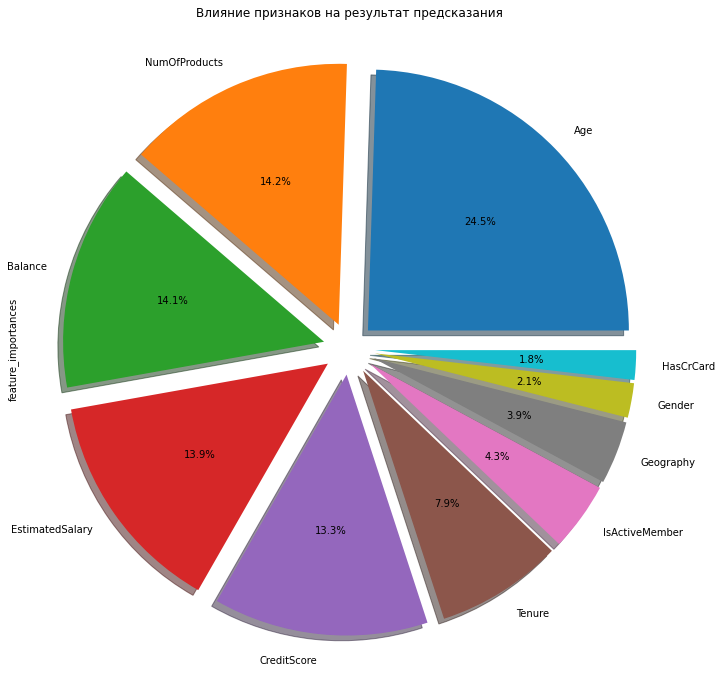

In [109]:
feature_importances.plot.pie(explode=[0.1]*len(x_churn_upsampled_train.drop(drop_ohe_columns, axis=1).columns),
                             labels = feature_importances.features,
                             y = 'feature_importances', autopct='%1.1f%%', shadow=True, legend=False, figsize=(12, 12), 
                             title='Влияние признаков на результат предсказания');

Признак 'Age' является наиболее влиящим на предсказанный результат (вес 0,25), далее следует 'NumOfProducts' (вес 0,14) и затем признаки 'EstimatedSalary', 'Balance' и 'CreditScore' (с весом 0,13).

## Матрица ошибок и ROC-кривая

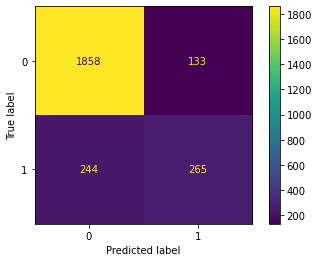

In [110]:
plot_confusion_matrix(estimator=rf3_best, y_true = y_churn_test, X = 
                      x_churn_test.drop(drop_ohe_columns, axis=1));
#confusion_matrix(y_churn_upsampled_test, rf3_best.predict(x_churn_upsampled_test.drop(drop_ohe_columns, axis=1)))

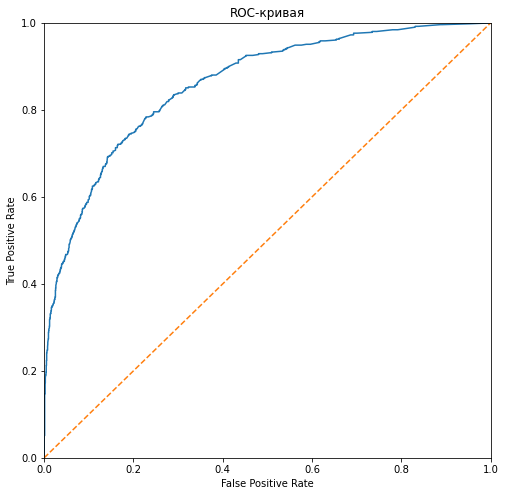

In [111]:
probabilities = rf3_best.predict_proba(x_churn_test.drop(drop_ohe_columns, axis=1))
probabilities_one = probabilities[:, 1]

fpr, tpr, thresholds = roc_curve(y_churn_test, probabilities_one)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

## Общий вывод

В процессе изучения и подготовки данных были заполнены пропуска в колонке Tenure, подготовлены категориальные данные с помощью методов One-Hot Encoding и Ordinal Encoding, а также отмасштабированы количественные данные.

Проведены эксперименты и сравнение по 3м датасетам:

1) churn - исходный предобработанный датафрейм с дисбалансом классов и class_weight = None

1) churn - исходный предобработанный датафрейм с дисбалансом классов и class_weight = 'balanced'

2) churn_upsampled - датафрейм перебалансированный методом upsampling

3) churn_upsampled - датафрейм перебалансированный методом downsampling

Сравнительная таблица обученных моделей:

In [112]:
display(results.sort_values('Test F1 Score', ascending=False))

,Data,Model,Train F1 Score,Test F1 Score
3,Downsampled,DecisionTree,0.752540,0.607660
7,Downsampled,RandomForest,1.000000,0.596096
6,Upsampled,RandomForest,1.000000,0.584344
0,Source: (class_weight = None),DecisionTree,0.643511,0.575311
1,Source: (class_weight = Balanced),DecisionTree,0.571644,0.568047
4,Source: (class_weight = None),RandomForest,0.999673,0.563725
5,Source: (class_weight = Balanced),RandomForest,0.999673,0.563725
2,Upsampled,DecisionTree,1.000000,0.512871
9,Source: (class_weight = Balanced),LogisticRegression,0.486701,0.504121
10,Upsampled,LogisticRegression,0.698348,0.501381


Наилучшие результаты показали модели DecisionTree и RandomForest соответственно. Самый эффективный для обучения датафрейм оказался датафрейм где дисбаланс классов устранен методом downsampling.

Лучшая модель:

dt4_best (DecisionTree) с настройками:

- Criterion : entropy
- max_depth : 6
- min_samples_leaf : 11

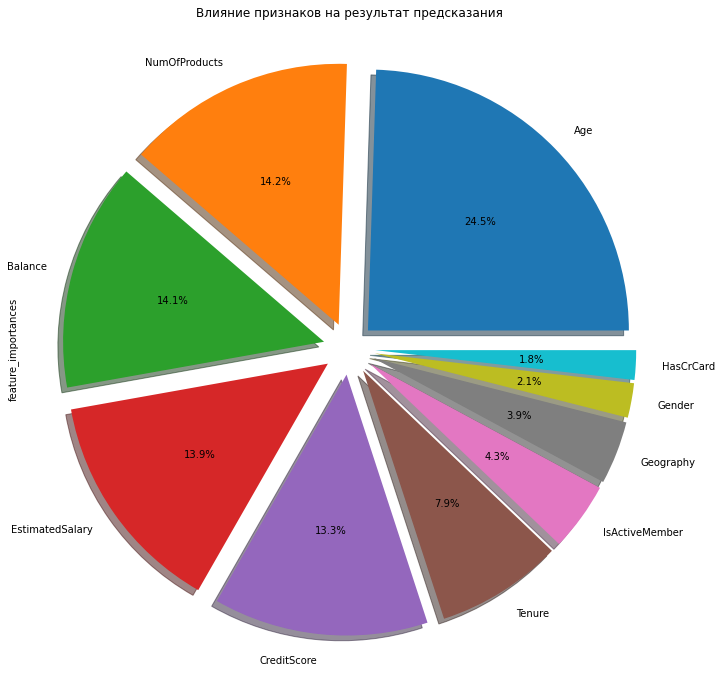

In [113]:
feature_importances.plot.pie(explode=[0.1]*len(x_churn_upsampled_train.drop(drop_ohe_columns, axis=1).columns),
                             labels = feature_importances.features,
                             y = 'feature_importances', autopct='%1.1f%%', shadow=True, legend=False, figsize=(12, 12), 
                             title='Влияние признаков на результат предсказания');

Признак 'Age' является наиболее влиящим на предсказанный результат (вес 0,25), далее следует 'NumOfProducts' (вес 0,14) и затем признаки 'EstimatedSalary', 'Balance' и 'CreditScore' (с весом 0,13).